### Abgabe 2: Die Wärmediffusionsgleichung ###

__Aufgabe 1:__

Die 1D-Wärmediffusionsgleichung lautet:
$$
\frac{\partial T}{\partial t}=\alpha \frac{\partial^2 T}{\partial x^2} \quad 0<x<L, \quad 0<y<W
$$
a) Leiten Sie die Finite-Differenzen-Matrix für zentrale Differenzen 2. Ordnung und für die verschiedenen Randbedingungen her. Und implementieren Sie eine Funktion, um diese zu erstellen.

b) Diskretisieren und lösen Sie die 1D-Wärmediffusionsgleichung. Nutzen Sie dazu Ihre Methode für zentrale räumliche Differenzen 2. Ordnung aus der letzten Abgabe. Leiten Sie die rechte Seite der diskretisierten Gleichung her und integrieren Sie sie in die in a) erstellte Matrix. Visualisieren Sie Ihre Ergebnisse.

Verwenden Sie eine _explizite_ Diskretisierung in der Zeit. Schreiben Sie einen Löser fuer die verscheidenen Randbedingungen. Nutzen Sie als Anfangsbedingungen eine Gauss-Kurve:
$$
T(x, t=0) = \frac{1}{2\pi\sigma} \ \exp \left(-\frac{x-\mu}{2\sigma} \right)
$$

i) _Dirichlet_-Randbedingungen:  $\quad T(x=0) = T_l, \ T(x=L) = T_r$

ii) adiabate _Neumann_-Randbedingungen:  $\quad \frac{\partial T}{\partial x}(x = 0) = 0, \ \frac{\partial T}{\partial x}(x = L) = 0 $

iii) _gemischte_ Randbedingungen:  $\quad T(x=0) = T_l, \ \frac{\partial T}{\partial x}(x = L) = 0 $

iv) _Periodische_ Randbedingungen:  $\quad T(x=0) = T(x=L)$

c) Verwenden Sie eine _implizite_ Diskretisierung in der Zeit. Schreiben Sie einen Löser fuer _Dirichlet_-Randbedingungen.

d) Verwenden Sie das _semi-implizite_ Crank-Nicolson-Verfahren. Schreiben Sie einen Löser fuer _Dirichlet_-Randbedingungen.

__Aufgabe 2:__

Überprüfen Sie die Stabilität Ihrer Löser fuer verschiedene _Fourier_-Zahlen. Visualisieren Sie den Einfluss der Fourier-Zahl auf die Lösung.

__Aufgabe 3:__

Die 2D-Wärmediffusionsgleichung lautet:
$$
\frac{\partial T}{\partial t}=\alpha \left(\frac{\partial^2 T}{\partial x^2}+\frac{\partial^2 T}{\partial y^2}\right) \quad 0<x<L, \quad 0<y<W
$$
Schreiben Sie einen expliziten Löser für eine periodische Domain und visualisieren Sie die transienten Temperaturprofile (z.B. mit einer Animation).

Die Solver sind gut und liefern korrekte Ergebnisse. Im Folgenden einige Kommentare zu den einzelnen Aufgaben:

**<span style="color:red">
Kommentare</span>**

_Aufgabe 1_

In den Markdown-Zellen kannst du mit `$...$` LaTeX-Text einfügen, z.B. `$T[1] = 0$` --> $T[1]=0$.

_Aufgabe 2_

Die Ergebnisse sehen gut aus. Du kannst mit `label = false` in der `plot`-Funktion die Legende für bessere Übersichtlichkeit verbergen.

_Aufgabe 3_

Dein Ansatz ist richtig. In 2D hast du eine Matrix $T[i,j]$ für T, die du mit deiner finite Differenzen-Matrix multiplizierst.

In [423]:
using LinearAlgebra
using Plots
using LaTeXStrings
using Animations
#gr()  Spezifiziert das Plots-Backend

__Set-up der Rechendomain__

Vorgabe der Gitter fuer x und t.

In [424]:
W = 10 # time that passes
L = 1 # Length of domain
alpha = 0.02 # diffusion coefficient
Nx = 21 # number of nodes in x direction 
dx = L/(Nx - 1) # grid spacing in x
x = (0:Nx-1) * dx # grid points in x
s = 1/2 # fourier number for task 1

0.5

### Aufgabe 1 ###

__Erstellen der FD Matrix 2. Ordnung__

In [425]:
function make_second_derivative_matrix(s, method="explicit")    
    N = length(x)
    if method == "explicit"
        main_diag = fill(1-2s, N)
        up_diag = fill(s, N-1)
        down_diag = fill(s, N-1)
    elseif method == "implicit"
        main_diag = fill(1+2s, N)
        up_diag = fill(-s, N-1)
        down_diag = fill(-s, N-1)
    else 
        println("Wrong method. Please only: explicit or implicit")
        return 0
    end
    main_diag[1] = main_diag[N] = 1 # for keeping the boundary conditions
    up_diag[1] = 0
    down_diag[N-1] = 0
    A = Tridiagonal(down_diag, main_diag, up_diag) # creating the tridiagonal matrix
    return A
end

make_second_derivative_matrix (generic function with 2 methods)

__Erstellen der Anfangsbedingungen__

In [426]:
sigma = 0.2 # constant for the gaussian curve
mu = L / 2 # constant for the gaussian curve
T(k) = 1/(sqrt(2*pi)*sigma) * exp(-(k-mu)^2/(2*sigma^2)) # initial condition (gaussian curve)
T_left = 0 # dirichlet boundary on the left side
T_right = 0 # dirichlet boundary on the right side

function initial_conditions(fourier)
    dt = fourier * dx^2 / alpha # time step size
    Nt = round(Int, W / dt + 1) # number of time steps
    return dt, Nt
end

initial_conditions (generic function with 1 method)

__Erstellen der verschiedenen rechten Seiten der Gleichung (Right Hand Sides / RHS)__

In [427]:

# Dirchlet RHS
RHS_dirichlet = T.(x) # initial condition
RHS_dirichlet[1] = T_left # boundary condition
RHS_dirichlet[Nx] = T_right

# Neumann RHS
RHS_neumann = T.(x)
RHS_neumann[1] = RHS_neumann[2]
RHS_neumann[Nx] = RHS_neumann[Nx-1]

# Mixed RHS
RHS_mixed = T.(x)
RHS_mixed[1] = T_left # dirichlet boundary
RHS_mixed[Nx] = RHS_mixed[Nx-1] # neumann boundary

# Periodic RHS
RHS_periodic = T.(x)
RHS_periodic[1] = RHS_periodic[Nx]

0.08764150246784272

__Explizite Loeser__

In [428]:
# Dirichlet RBs
function explicit_solver_dirichlet(s)
    dt, Nt = initial_conditions(s)
    U_old = RHS_dirichlet # storing initial condition
    U_all = zeros(Nx, Nt) # solution for every time step
    A = make_second_derivative_matrix(s, "explicit")
    for counter in 1:Nt
        U_all[:, counter] = U_old # storing old solution
        U_new = A * U_old # solving linear system
        U_old = U_new
    end
    return U_all
end

# Neumann-RBs
function explicit_solver_neumann(s)
    dt, Nt = initial_conditions(s)
    U_old = RHS_neumann
    U_all = zeros(Nx, Nt)
    A = make_second_derivative_matrix(s, "explicit")
    for counter in 1:Nt
        U_all[:, counter] = U_old
        U_new = A * U_old
        U_new[1] = U_new[2]
        U_new[Nx] = U_new[Nx-1]
        U_old = U_new
    end
    return U_all
end

# gemischte RBs
function explicit_solver_mixed(s)
    dt, Nt = initial_conditions(s)
    U_old = RHS_mixed
    U_all = zeros(Nx, Nt)
    A = make_second_derivative_matrix(s, "explicit")
    for counter in 1:Nt
        U_all[:, counter] = U_old
        U_new = A * U_old
        U_new[Nx] = U_new[Nx-1]
        U_old = U_new
    end
    return U_all
end

# periodische RBs
function explicit_solver_periodic(s)
    dt, Nt = initial_conditions(s)
    U_old = RHS_periodic
    U_all  = zeros(Nx, Nt)
    A = make_second_derivative_matrix(s, "explicit")
    for counter in 1:Nt
        U_all[:, counter] = U_old
        U_new = A * U_old
        U_old = U_new
    end
    return U_all
end

explicit_solver_periodic (generic function with 1 method)

__Impliziter Loeser__

In [429]:
function implicit_solver_dirichlet(s)
    dt, Nt = initial_conditions(s)
    RHS_dirichlet[2] += s * RHS_dirichlet[1]
    RHS_dirichlet[Nx-1] += s * RHS_dirichlet[Nx]
    U_old = RHS_dirichlet
    U_all = zeros(Nx, Nt)
    A = make_second_derivative_matrix(s, "implicit")
    for counter in 1:Nt
        U_all[:, counter] = U_old
        U_new = A \ U_old
        U_old = U_new
    end
    return U_all
end

implicit_solver_dirichlet (generic function with 1 method)

__Crank-Nicolson__

In [430]:
function solver_crank_nicolson(s)
    dt, Nt = initial_conditions(s)
    N = length(x)
    main_diag_A = fill(2+2s, N) # main diagonal of the matrix A
    up_diag_A = fill(-s, N-1) # upper diagonal of the matrix A
    down_diag_A = fill(-s, N-1) # lower diagonal of the matrix A
    main_diag_B = fill(2-2s, N)
    up_diag_B = fill(s, N-1)
    down_diag_B = fill(s, N-1)
    main_diag_A[1] = main_diag_A[N] = 1 # for keeping the boundary condition
    up_diag_A[1] = 0
    down_diag_A[N-1] = 0
    main_diag_B[1] = main_diag_B[N] = 1
    up_diag_B[1] = 0
    down_diag_B[N-1] = 0
    A = Tridiagonal(down_diag_A, main_diag_A, up_diag_A) # creating tridiagonal matrix of the 3 diagonals
    B = Tridiagonal(down_diag_B, main_diag_B, up_diag_B)
    U_old = RHS_dirichlet
    U_all = zeros(Nx, Nt)
    for counter in 1:Nt
        U_all[:, counter] = U_old
        U_new = inv(A) * B * U_old # solving the linear system
        U_old = U_new
    end
    return U_all
end

solver_crank_nicolson (generic function with 1 method)

__Loesen mit den verschiedenen Methoden__

In [431]:
U_dirichlet_explicit = explicit_solver_dirichlet(s)
U_neumann_explicit = explicit_solver_neumann(s)
U_mixed_explicit = explicit_solver_mixed(s)
U_periodic_explicit = explicit_solver_periodic(s)
U_dirichlet_implicit = implicit_solver_dirichlet(s)
U_crank_nicolson = solver_crank_nicolson(s)

21×161 Matrix{Float64}:
 0.0       0.0       0.0       0.0       …  0.0        0.0        0.0
 0.158698  0.14602   0.146922  0.151052     0.0368167  0.0363662  0.0359213
 0.269955  0.288772  0.300722  0.311745     0.0727269  0.071837   0.070958
 0.431387  0.456614  0.47723   0.493823     0.106846   0.105539   0.104248
 0.647588  0.670599  0.690059  0.705953     0.138335   0.136642   0.13497
 0.913245  0.92717   0.938142  0.946405  …  0.166417   0.164381   0.162369
 1.20985   1.20849   1.20536   1.20077      0.190402   0.188072   0.185771
 1.50569   1.48513   1.46474   1.44462      0.209698   0.207132   0.204597
 1.76033   1.72076   1.68357   1.64854      0.223831   0.221092   0.218386
 1.93334   1.87973   1.83028   1.78449      0.232452   0.229607   0.226798
 ⋮                                       ⋱                        ⋮
 1.76033   1.72076   1.68357   1.64854      0.223831   0.221092   0.218386
 1.50569   1.48513   1.46474   1.44462      0.209698   0.207132   0.204597
 1.20985   1.

__Plotten der Loesungen Aufgabe 1b__

Plots.AnimatedGif("C:\\Users\\pbreu\\AppData\\Local\\Temp\\jl_dILwhOt29I.gif")
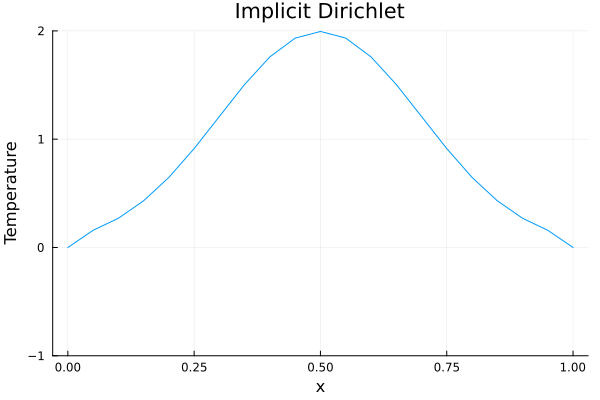

┌ Info: Saved animation to C:\Users\pbreu\AppData\Local\Temp\jl_dILwhOt29I.gif
└ @ Plots C:\Users\pbreu\.julia\packages\Plots\ju9dp\src\animation.jl:156


In [432]:
dt, Nt = initial_conditions(s)
@gif for i in 1:Nt
    plot(x, U_dirichlet_explicit[:, i], legend=:topright, label = false)
    xlabel!("x")
    ylabel!("Temperature")
    ylims!(-1, 2)
    title!("Implicit Dirichlet")
end

┌ Info: Saved animation to C:\Users\pbreu\AppData\Local\Temp\jl_xgpSdwHwxQ.gif
└ @ Plots C:\Users\pbreu\.julia\packages\Plots\ju9dp\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\pbreu\\AppData\\Local\\Temp\\jl_xgpSdwHwxQ.gif")
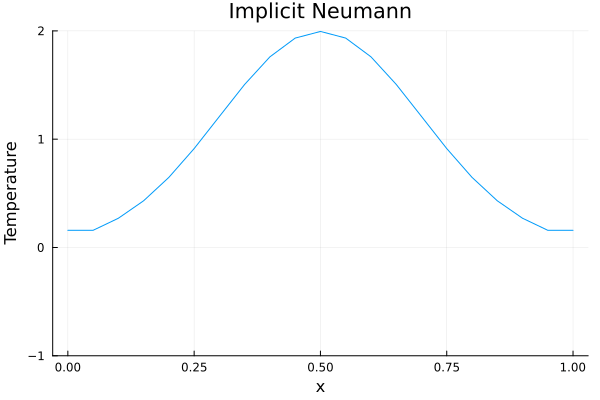

In [433]:
@gif for i in 1:Nt
    plot(x, U_neumann_explicit[:, i], legend=:topright, label = false)
    xlabel!("x")
    ylabel!("Temperature")
    ylims!(-1, 2)
    title!("Implicit Neumann")
end

┌ Info: Saved animation to C:\Users\pbreu\AppData\Local\Temp\jl_vypaZwNkxs.gif
└ @ Plots C:\Users\pbreu\.julia\packages\Plots\ju9dp\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\pbreu\\AppData\\Local\\Temp\\jl_vypaZwNkxs.gif")
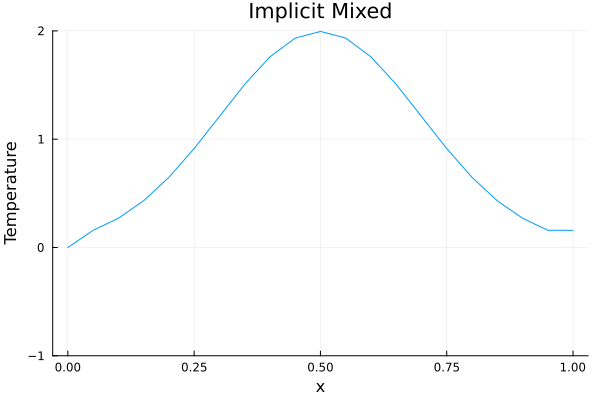

In [434]:
@gif for i in 1:Nt
    plot(x, U_mixed_explicit[:, i], legend=:topright, label = false)
    xlabel!("x")
    ylabel!("Temperature")
    ylims!(-1, 2)
    title!("Implicit Mixed")
end

┌ Info: Saved animation to C:\Users\pbreu\AppData\Local\Temp\jl_NqzsZMFuJq.gif
└ @ Plots C:\Users\pbreu\.julia\packages\Plots\ju9dp\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\pbreu\\AppData\\Local\\Temp\\jl_NqzsZMFuJq.gif")
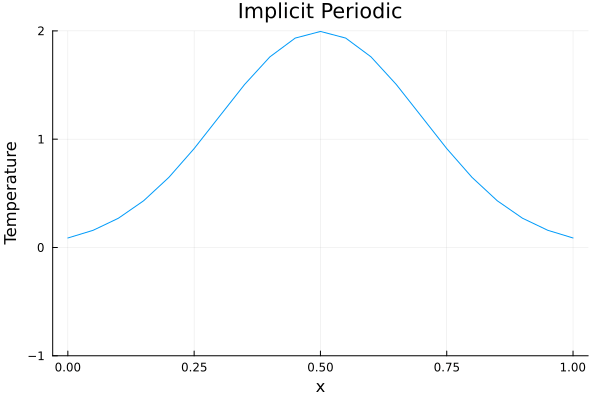

In [435]:
@gif for i in 1:Nt
    plot(x, U_periodic_explicit[:, i], legend=:topright, label = false)
    xlabel!("x")
    ylabel!("Temperature")
    ylims!(-1, 2)
    title!("Implicit Periodic")
end

__Plotten der Loesungen Aufgabe 1c__

┌ Info: Saved animation to C:\Users\pbreu\AppData\Local\Temp\jl_l61YhwPMJI.gif
└ @ Plots C:\Users\pbreu\.julia\packages\Plots\ju9dp\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\pbreu\\AppData\\Local\\Temp\\jl_l61YhwPMJI.gif")
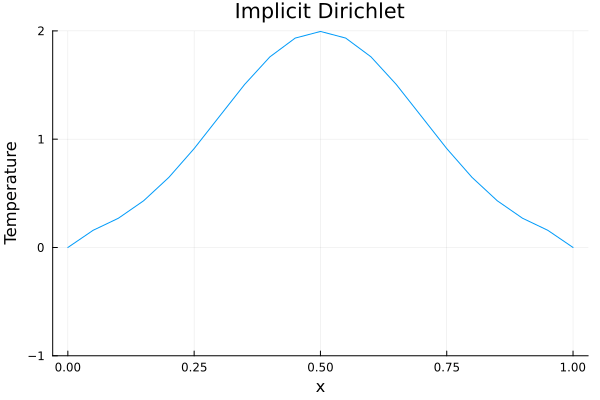

In [436]:
@gif for i in 1:Nt
    plot(x, U_dirichlet_implicit[:, i], legend=:topright, label = false)
    xlabel!("x")
    ylabel!("Temperature")
    ylims!(-1, 2)
    title!("Implicit Dirichlet")
end

__Plotten der Loesungen Aufgabe 1d__

┌ Info: Saved animation to C:\Users\pbreu\AppData\Local\Temp\jl_JGH272zubI.gif
└ @ Plots C:\Users\pbreu\.julia\packages\Plots\ju9dp\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\pbreu\\AppData\\Local\\Temp\\jl_JGH272zubI.gif")
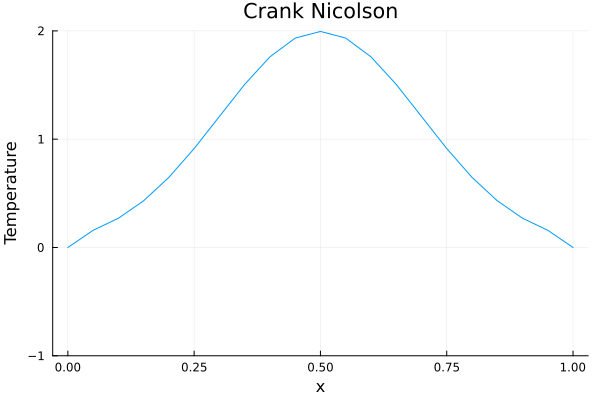

In [437]:

@gif for i in 1:Nt
    plot(x, U_crank_nicolson[:, i], legend=:topright, label = false)
    xlabel!("x")
    ylabel!("Temperature")
    ylims!(-1, 2)
    title!("Crank Nicolson")
end

### Aufgabe 2

__Solver fuer verschiedene Fourierzahlen__

In [438]:
function solving_for_diff_fourier(s_vector, method="Explicit Dirichlet")
    U_final = [] # final vector that stores the solution of every fourier number
    for (i, s_) in enumerate(s_vector)
        if method == "Explicit Dirichlet"
            U_final_temp = explicit_solver_dirichlet(s_)
        elseif method == "Explicit Neumann"
            U_final_temp = explicit_solver_neumann(s_)
        elseif method == "Explicit Mixed"
            U_final_temp = explicit_solver_mixed(s_)
        elseif method == "Explicit Periodic"
            U_final_temp = explicit_solver_periodic(s_) 
        elseif method == "Implicit Dirichlet"
            U_final_temp = implicit_solver_dirichlet(s_)
        elseif method == "Crank Nicolson"
            U_final_temp = solver_crank_nicolson(s_)      
        end
        push!(U_final, U_final_temp) # storing solution for each fourier number in one vector
    end
    return U_final
end 

solving_for_diff_fourier (generic function with 2 methods)

__Setup der benoetigten Variablen__

In [439]:
s_vector = [0.1, 0.5, 1.0, 2.0] # vector for different fourier numbers
U_exp_dirichlet_fourier = solving_for_diff_fourier(s_vector, "Explicit Dirichlet")
U_exp_neumann_fourier = solving_for_diff_fourier(s_vector, "Explicit Neumann")
U_exp_mixed_fourier = solving_for_diff_fourier(s_vector, "Explicit Mixed")
U_exp_periodic_fourier = solving_for_diff_fourier(s_vector, "Explicit Periodic")
U_imp_dirichlet_fourier = solving_for_diff_fourier(s_vector, "Implicit Dirichlet")
U_crank_nicolson_fourier = solving_for_diff_fourier(s_vector, "Crank Nicolson")

4-element Vector{Any}:
 [0.0 0.0 … 0.0 0.0; 0.15869825917833716 0.15459541673557495 … 0.03601067510018751 0.035922113977828615; … ; 0.15869825917833724 0.15459541673557498 … 0.03601067510018832 0.035922113977829434; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.15869825917833716 0.14602048614407295 … 0.03636624511242266 0.03592125596516634; … ; 0.15869825917833724 0.14602048614407298 … 0.036366245112422715 0.03592125596516639; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.15869825917833716 0.14316656334582434 … 0.03681403284713395 0.03591857456077583; … ; 0.15869825917833724 0.14316656334582437 … 0.03681403284713397 0.03591857456077585; 0.0 0.0 … 0.0 0.0]
 [0.0 -6.175980470790771e-18 … -2.2895598992960566e-16 -2.309983571495048e-16; 0.15869825917833716 0.14557129607283947 … 0.03772082807427181 0.03590784720804371; … ; 0.15869825917833724 0.14557129607283945 … 0.03772082807427203 0.03590784720804393; 0.0 0.0 … 0.0 0.0]

__Berechnung und Plotten der Ergebnisse__

In [440]:
function plot_for_different_fourier(U) # function for plotting for the 4 different fourier numbers
    p1 = plot(x, U[1], title="Fourier 0.1", legend=:outertopright, xlabel="Spatial Coordinate (x)", ylabel="Temperature (u)")
    p2 = plot(x, U[2], title="Fourier 0.5", legend=:outertopright, xlabel="Spatial Coordinate (x)", ylabel="Temperature (u)")
    p3 = plot(x, U[3], title="Fourier 1.0", legend=:outertopright, xlabel="Spatial Coordinate (x)", ylabel="Temperature (u)")
    p4 = plot(x, U[4], title="Fourier 2.0", legend=:outertopright, xlabel="Spatial Coordinate (x)", ylabel="Temperature (u)")
    
    plot(p1, p2, p3, p4, layout=(2,2))
end

plot_for_different_fourier (generic function with 1 method)

__Stabilitätsanalyse Expliziter Dirichlet__

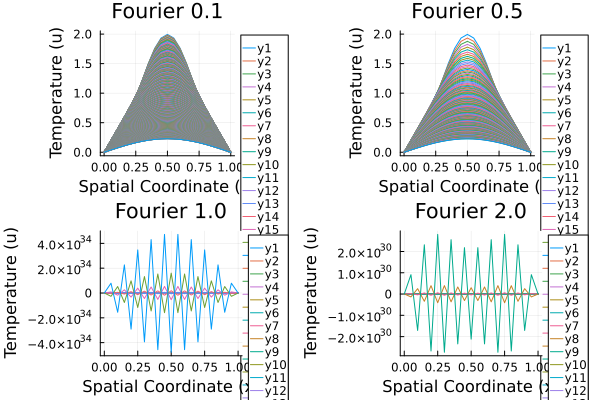

In [441]:
plot_for_different_fourier(U_exp_dirichlet_fourier)

__Stabilitätsanalyse Expliziter Neumann__

__Stabilitätsanalyse Explizite Mixed__

### Aufgabe 3

__Setup der Variablen__

In [447]:
W_task3 = 1 # width of domain for task 3
Ny = 21 # number of nodes in y direction for task 3
dy = W_task3/(Ny - 1) # grid spacing in y for task 3
y = (0:Ny-1) * dy # grid points in y for task 3
mu_x = L/2
mu_y = W_task3/2
sigma_x = sigma_y = 1

1

__Funktionen fuer Anfangsbedingungen und Solver__

In [448]:
function initial_condition2d(x, y)
    T_final = zeros(Nx, Ny)
    T_(x_, y_) = exp(-((x_ - mu_x)^2 / 2 * sigma_x^2) + (y_ - mu_y)^2 / 2 * sigma_y^2) # 2d gaussian curve as initial condition
    T_final = T_.(x, y)
    return T_final
end 

function solve_explicit_2d(s)
    dt, Nt = initial_conditions(s)
    U = initial_condition2d(x, y)
    U[1, :] = U[Nx, :] # periodic boundary condition
    U_all = zeros[Nx, Ny, Nt]
    for k in 1:Nt # for each time step
        for i in 2:Ny-1 # for each inner point in y direction
            for j in 2:Nx-1 # for each inner point in x direction
                U[i, j] = (U[i+1, j] ++ U[i-1, j] + U[i, j+1] + U[i, j-1] - 4* U[i, j]) + U[i, j] # explicit finite differences
                push!(U_all, U[i, j]) # storing every time step
            end
        end
    end
    return U_all # returning solution
end

solve_explicit_2d (generic function with 1 method)

__Plotten der Ergebnisse__

### Explanation of the code:

First of all we declare some constants for our domain. like the length and the time, that passes.
Also the grid spacing and the number of nodes are calculated.

Matrix Creation:
- The function make_second_derivative_matrix() creates the 2nd order central difference matrix for implicit and explicit methods.
- The first row (1, 0, ... 0) ensures that the boundary condition is fullfilled through all time steps
- The last row (0 ... 0, 1) does this also.

After that we deaclare our initial conditions. (Gaussian curve) 
The function initial_conditions() calculates our number of time steps and the time step size with respect to the chosen fourier number.

The RHS is derived by the given boundary condition. 
- For dirichlet, the first and last points are remaining constant. (here 0)
- For neumann, T(1) = T(2) and T(Nx) = T(Nx-1)
- For mixed, we have a combination of dirichlet and neumann.
- For periodic, we set T(1) = T(Nx), so that they "wrap around" and stay at the same value at each boundary.

The explicit solvers all solve the system by multiplying the matrix with the old RHS. After that we store each step in the variable named U_all so that we can plot each step easier.

For neumann we also need to make sure, that U[1] = U[2] and U[Nx] = U[Nx-1] for each step. 

The implicit solver does the same thing as the explicit one with one change. We need to invert the matrix. This does the backslash.

After using finite differences for Crank_Nicolson we can construct two matrices, A and B for easier calculation.
U_new gets calculates by U_old * inv(A) * B

The plots show each time step for each method and the explicit solvers are in one window for better comparison of the boundary conditions.
Every time step is here in a different colour.

For solving with different fourier numbers we have a function that takes an array of fourier numbers and the chosen method as inputs.
It now calculates the solution for each fourier number and stores each time step of each fourier number in one big array named U_final.
The push! command helps with easier storing the different solutions of each fourier number. U_final[1] has all time steps of the chosen method with the first fourier number and so on.

We then declare our fourier vector and solve for each method.

Stability analysis:
- In the plots below we see, that the explicit methods are only stable for fourier numbers <= 0.5.

- The implicit and Crank-Nicolson method can also handle higher fourier numbers.

2d heat equation:
- I sadly couldn't get it to work in time... My idea was to use a 2d gaussian curve as initial condition and to set the points on the left wall equal to the calculation of the points on the right wall for each time step. This would ensure the periodic domain.